# Credit Score Classification
### By : Shivam Chaudhary

### Problem Statement 
Develop a credit score classification model using machine learning to assess the creditworthiness of individuals applying for loans or credit lines.

### Objective
The objective is to design and train a predictive model that accurately classifies applicants into predefined credit score categories based on their financial history, demographic information, and other relevant factors. The model should optimize for both accuracy and interpretability to aid in decision-making for lending institutions.

In [56]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_score,classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV
import random
import pickle
from sklearn.impute import KNNImputer
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm



# ML algorithms 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier 
from xgboost import XGBClassifier 
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [57]:
# Load data

pd.set_option('display.max_columns',None)
df = pd.read_csv(r"D:\My work\Credit Risk Data\train.csv")
print(df.shape)
df.head(3)

(100000, 28)


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.84,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.00,_,809.98,26.82,22 Years and 1 Months,No,49.57,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.00,Good,809.98,31.94,NaN,No,49.57,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.00,Good,809.98,28.61,22 Years and 3 Months,No,49.57,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good


"In the dataset at hand, there are 28 columns, all of which pertain to credit score evaluation. Let us proceed with a comprehensive and thorough analysis of these variables."

In [58]:
# duplicate row check

df.duplicated().sum()

0

In [59]:
# check null values

df.drop(columns=['ID'],inplace=True)
df.isna().sum()

Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

Note
- "In the dataset, each row contains a 'name' and a 'customer ID', which are identical. However, certain entries in the 'name' column are missing. Given that the absence of these names does not impact the analysis and they do not contribute meaningfully to it, we can drop the 'name' column."
- "In 15,002 rows, the 'Monthly_Inhand_Salary' column contains missing values. As this column holds significance for our analysis, I propose to examine and compare it with 'customer ID', 'month', and 'annual income'. This approach will facilitate a comprehensive understanding, enabling informed decisions regarding the appropriate method for filling in these missing values."
- "The 'Type of loan' column exhibits 11,408 null values, a significant portion. Dropping the column or null values isn't viable due to its importance. Instead, we suggest analyzing it alongside the 'number of loans' column and evaluating its statistical traits and distribution to glean insights. Moreover, with 6261 unique values, some types may be prevalent across multiple entries, warranting consideration of utilizing the mode or labeling unspecified values as 'unknown type'."
- "I suspect a correlation between 'Num_of_Delayed_Payment' and 'Delay_from_due_date', suggesting the potential to drop 'Num_of_Delayed_Payment'. However, a decision will be made post-analysis."
- "Upon initial observation of the 'Num_Credit_Inquiries' column, utilizing a KNN imputer to handle null values appears promising. However, a final decision will be made following analysis."
- "Correlations indicate 'Credit_History_Age' can be dropped post-analysis due to its association with 'age' and 'month'. For 'Amount_invested_monthly', I propose using KNN imputation to handle suspected errors/null values. Considering the low count of null values, 'Monthly_Balance' is recommended for removal."

In [60]:
# dealing with null values

# Name
df['Occupation'] = df['Occupation'].str.replace('_','')
df['Annual_Income'] = df['Annual_Income'].str.replace('_','')
df = df.drop(columns=['Name']).reset_index(drop=True)

# Monthly_Inhand_Salary
df['Monthly_Inhand_Salary'] = df.groupby(['Customer_ID', 'Occupation', 'Annual_Income'])['Monthly_Inhand_Salary'].ffill()
df['Occupation'] = df['Occupation'].replace('', np.nan)
df['Occupation'] = df['Occupation'].fillna(df.groupby('Customer_ID')['Occupation'].transform(lambda x: x.mode()[0]))
df['Monthly_Inhand_Salary'] = df['Monthly_Inhand_Salary'].fillna(df.groupby(['Customer_ID', 'Occupation', 'Annual_Income'])['Monthly_Inhand_Salary'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan))
df.dropna(subset=['Monthly_Inhand_Salary'], inplace=True)

# Type_of_Loan
df['Type_of_Loan'] = df['Type_of_Loan'].fillna('Not Specified')

# Num_of_Delayed_Payment
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace('_', '')
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'], errors='coerce')
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].fillna((df['Num_of_Delayed_Payment'].shift().fillna(0) + df['Num_of_Delayed_Payment'].shift(-1).fillna(0) + df['Num_of_Delayed_Payment'].shift(-2).fillna(0) + df['Num_of_Delayed_Payment'].shift(1).fillna(0) + df['Num_of_Delayed_Payment'].shift(2).fillna(0)) / 5)
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].astype(int)

# Num_Credit_Inquiries
df['Num_Credit_Inquiries'] = df['Num_Credit_Inquiries'].fillna(df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(lambda x: x.mode()[0]))

# Credit_History_Age
df['Age'] = df['Age'].str.replace('-','').str.replace('_','')
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df.loc[df['Age'] >= 100, 'Age'] = np.nan
df['Age'] = df['Age'].fillna(df.groupby('Customer_ID')['Age'].transform(lambda x: x.mode()[0]))
df['Age'] = df['Age'].astype(int)
df['Credit_History_Age'] = df['Credit_History_Age'].str.extract(r'(\d+)\s*Years\s+and\s+(\d+)\s+Months').apply(lambda x: f"{x[0]}.{x[1]}", axis=1)
df['Credit_History_Age'] = df['Credit_History_Age'].replace('nan.nan', np.nan)
import re

def modify_number(number):
    match = re.match(r'^(\d+)\.(\d)$', str(number))
    if match:
        return f"{match.group(1)}.0{match.group(2)}"
    else:
        return number
df['Credit_History_Age'] = df['Credit_History_Age'].apply(modify_number)
df = df.reset_index(drop=True)
for i in range(1, len(df)):
    if pd.isnull(df.at[i, 'Credit_History_Age']):
        if df.at[i, 'Age'] == df.at[i-1, 'Age']:
            df.at[i, 'Credit_History_Age'] = float(df.at[i-1, 'Credit_History_Age']) + 0.01
df = df.dropna(subset=['Credit_History_Age']).reset_index(drop=True)

def fill_missing_with_neighbors_mode(series):
    return series.fillna(series.rolling(5, min_periods=1).apply(lambda x: mode(x, nan_policy='omit')[0][0]))
def fill_missing_with_neighbors_mean(series):
    return series.fillna(series.rolling(5, min_periods=1).mean())
# Amount_invested_monthly
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].replace('__10000__', np.nan)
df['Amount_invested_monthly'] = fill_missing_with_neighbors_mean(df['Amount_invested_monthly'])
df = df.dropna(subset=['Amount_invested_monthly']).reset_index(drop=True)

# Monthly_Balance
df['Monthly_Balance'] = df['Monthly_Balance'].replace('__-333333333333333333333333333__',np.nan)
df['Monthly_Balance'] = fill_missing_with_neighbors_mean(df['Monthly_Balance'])


In [61]:
df.isna().sum().sum()

0

"All the null values are treated"

In [62]:
# checking unwanted characters in dataset

special_chars = set(['/','?','#','-','_','<','>','+','@','!',' ','$','%','^','&'])
result = df.applymap(lambda x: any(char in special_chars for char in str(x) if isinstance(x, str)))

result.sum()

Customer_ID                 97931
Month                           0
Age                             0
SSN                         97931
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary           0
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                  8491
Type_of_Loan                97931
Delay_from_due_date             0
Num_of_Delayed_Payment          0
Changed_Credit_Limit         3604
Num_Credit_Inquiries            0
Credit_Mix                  19795
Outstanding_Debt              988
Credit_Utilization_Ratio        0
Credit_History_Age              0
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly         0
Payment_Behaviour           97931
Monthly_Balance                 0
Credit_Score                    0
dtype: int64

"We can drop the 'SSN' column as it pertains to social security numbers, which are not relevant at this level. The 'Customer_ID' column, with its underscores, remains acceptable and can be retained."

In [63]:
# dealing with unwanted characters

# SSN
df.drop(columns=['SSN'],inplace=True)

# Num_of_Loan
df['Num_of_Loan'] = df['Num_of_Loan'].replace(['_', '-'], '', regex=True)
df['Num_of_Loan'] = pd.to_numeric(df['Num_of_Loan'], errors='coerce')
df.loc[df['Num_of_Loan'] >= 50, 'Num_of_Loan'] = np.nan
def fill_missing_with_neighbors_mode(series):
    return series.fillna(series.rolling(5, min_periods=1).apply(lambda x: mode(x, nan_policy='omit')[0][0]))
df['Num_of_Loan'] = fill_missing_with_neighbors_mode(df['Num_of_Loan'])

# Type_of_Loan (No change required)

# Changed_Credit_Limit
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].replace('-','').replace('_','').replace('',np.nan)
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].astype(float).abs().round(2)
df['Changed_Credit_Limit'] = fill_missing_with_neighbors_mode(df['Changed_Credit_Limit'])

# Credit_Mix
df['Credit_Mix'] = df['Credit_Mix'].replace('_','').replace('',np.nan)
df['Credit_Mix'] = df['Credit_Mix'].fillna(method='ffill')
df = df.dropna(subset=['Credit_Mix']).reset_index(drop=True)

# Outstanding_Debt
df['Outstanding_Debt'] = df['Outstanding_Debt'].replace('_','').str.replace('_','').replace('',np.nan)

# Payment_Behaviou
df['Payment_Behaviour'] = df['Payment_Behaviour'].replace('!@9#%8','').replace('',np.nan)
df['Payment_Behaviour'] = df['Payment_Behaviour'].fillna(method='ffill')

In [64]:
df.isna().sum().sum()

0

"All unwanted charaters/value are treated"

### EDA

In [65]:
# check data loss

data_loss = 100000 - df.shape[0]
print('Data Loss : ',data_loss, 'Rows')

Data Loss :  2070 Rows


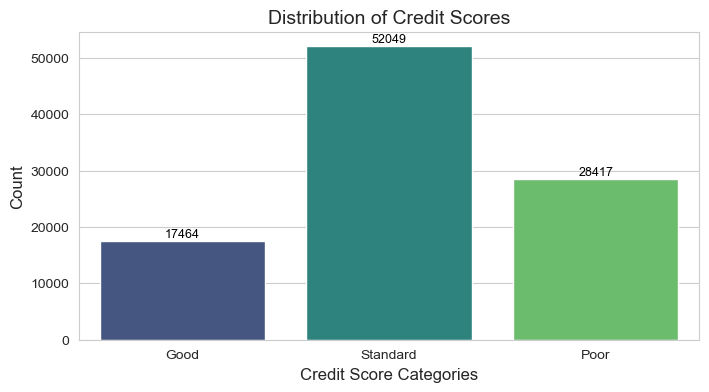

In [66]:
# Check label balance

sns.set_style("whitegrid")
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df, x='Credit_Score', palette='viridis')

plt.xlabel('Credit Score Categories', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Credit Scores', fontsize=14)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()


"The label distribution appears balanced, with three distinct classes, exhibiting a proportional ratio close to 5:3:2."

In [67]:
df.head(3)

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,CUS_0xd40,February,23,Scientist,19114.12,1824.84,3,4,3,4.00,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,5,11.27,4.00,Good,809.98,31.94,22.02,No,49.57,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
1,CUS_0xd40,March,23,Scientist,19114.12,1824.84,3,4,3,4.00,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.00,Good,809.98,28.61,22.03,No,49.57,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
2,CUS_0xd40,April,23,Scientist,19114.12,1824.84,3,4,3,4.00,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.00,Good,809.98,31.38,22.04,No,49.57,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good


In [68]:
# Catagorical and continues columns

cat = ['Customer_ID', 'Month','Occupation','Type_of_Loan','Credit_Mix','Payment_of_Min_Amount','Payment_Behaviour',
       'Credit_Score']

con = ['Age','Annual_Income','Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card','Interest_Rate',
       'Num_of_Loan','Delay_from_due_date','Num_of_Delayed_Payment', 'Changed_Credit_Limit','Num_Credit_Inquiries',
       'Outstanding_Debt','Credit_Utilization_Ratio', 'Credit_History_Age','Total_EMI_per_month','Amount_invested_monthly',
       'Monthly_Balance']

print(len(cat)+len(con))

25


In [69]:
# unique values check in categorical columns

for i in cat:
    print(f'Number of unique {i} : ',len(df[i].value_counts()))

Number of unique Customer_ID :  12500
Number of unique Month :  8
Number of unique Occupation :  15
Number of unique Type_of_Loan :  6260
Number of unique Credit_Mix :  3
Number of unique Payment_of_Min_Amount :  3
Number of unique Payment_Behaviour :  6
Number of unique Credit_Score :  3


"Given the dataset's 97,930 rows with 12,500 unique customers, consolidating data for yearly analysis is viable. However, analyzing loan types requires careful consideration due to the extensive variety of over 6,000 categories."

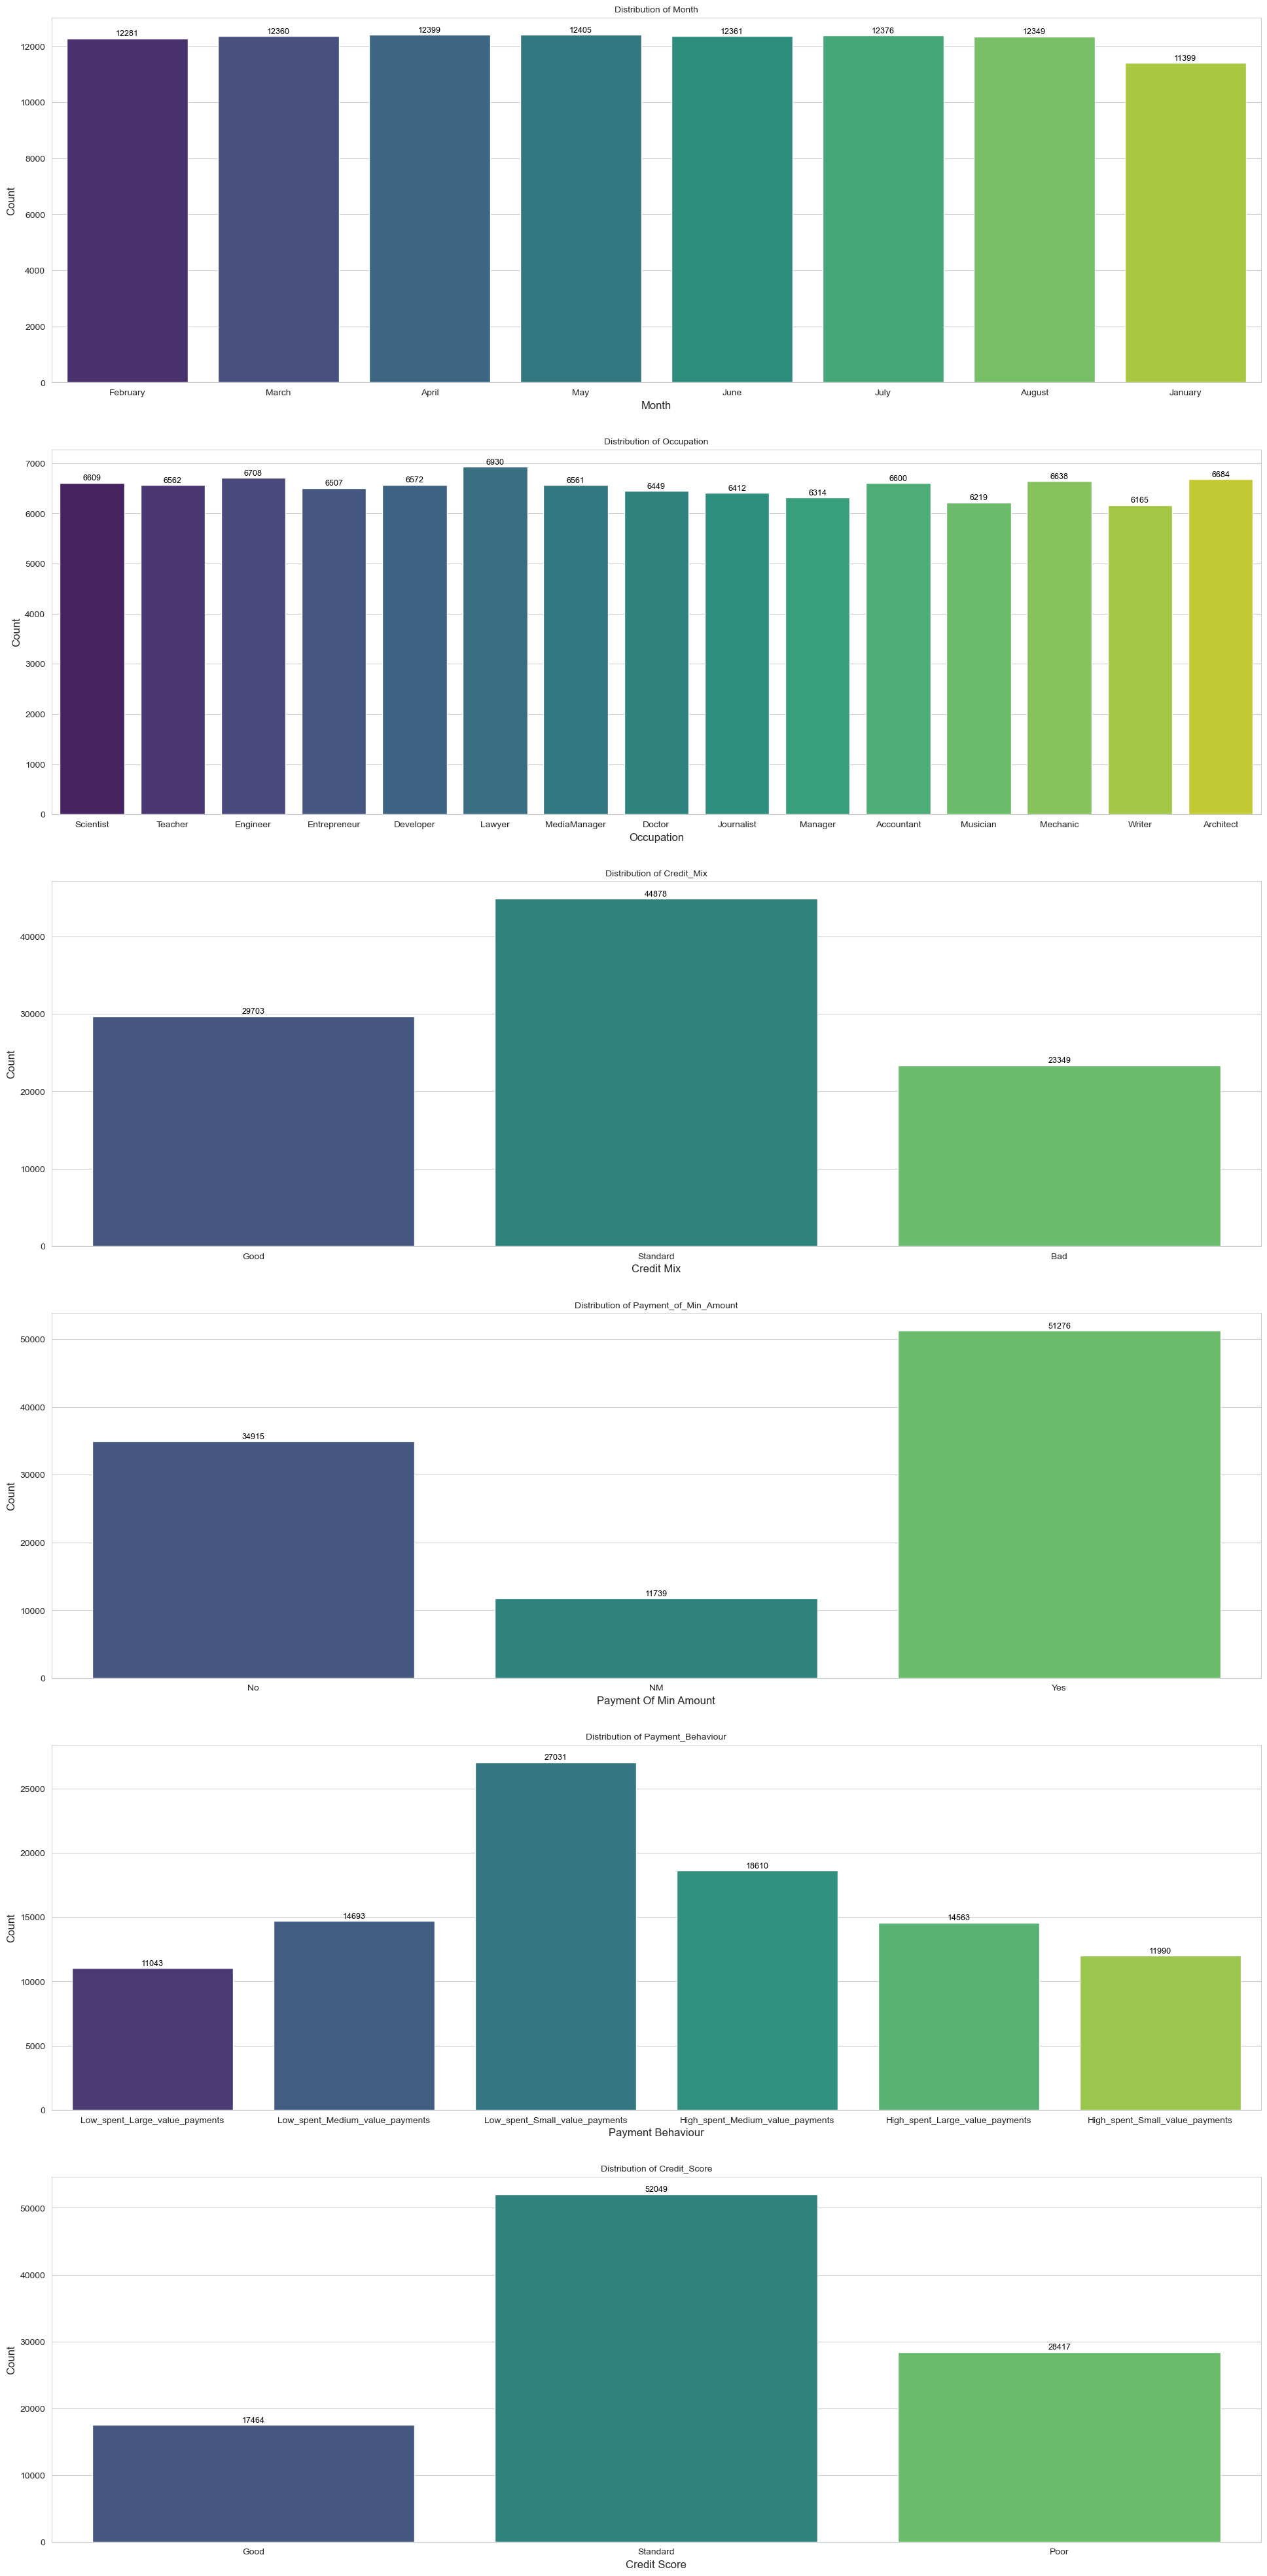

In [70]:
# check Occurance

cat = ['Month', 'Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']

plt.figure(figsize=(20, 40))
num_plots = len(cat)
num_cols = 1
num_rows = (num_plots + num_cols - 1) // num_cols

for index, i in enumerate(cat):
    plt.subplot(num_rows, num_cols, index+1) 
    sns.set_style("whitegrid")
    ax = sns.countplot(data=df, x=i, palette='viridis')
    plt.xlabel(i.replace('_', ' ').title(), fontsize=12)  
    plt.ylabel('Count', fontsize=12)
    plt.title(f'Distribution of {i}', fontsize=10) 
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout(pad=3.0) 
plt.show()



"The majority of columns exhibit nearly equal distribution among their unique values, while a few show slight variations in their count of unique values. However, these variations are minor and do not significantly impact the overall distribution."

In [71]:
# Type of load check

df['Type_of_Loan'].unique()[0:10]

array(['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan',
       'Credit-Builder Loan', 'Auto Loan, Auto Loan, and Not Specified',
       'Not Specified', 'Credit-Builder Loan, and Mortgage Loan',
       'Not Specified, Auto Loan, and Student Loan',
       'Personal Loan, Debt Consolidation Loan, and Auto Loan',
       'Not Specified, and Payday Loan',
       'Credit-Builder Loan, Personal Loan, and Auto Loan',
       'Payday Loan, and Payday Loan'], dtype=object)

"To streamline our analysis, we'll address the repetition of values in the column, which is contributing to over 6000 categories. By removing duplicates, we aim to refine our data for a clearer examination."

In [72]:
def remove_duplicates(entry):
    loan_types = [loan.strip() for loan in entry.split(',')]
    unique_loans = list(set(loan_types))
    return ', '.join(unique_loans)

df['Type_of_Loan'] = df['Type_of_Loan'].apply(remove_duplicates)


In [73]:
# Type of load check

df['Type_of_Loan'].unique()[0:10]

array(['Personal Loan, Credit-Builder Loan, Auto Loan, and Home Equity Loan',
       'Credit-Builder Loan', 'and Not Specified, Auto Loan',
       'Not Specified', 'Credit-Builder Loan, and Mortgage Loan',
       'and Student Loan, Not Specified, Auto Loan',
       'Personal Loan, Debt Consolidation Loan, and Auto Loan',
       'Not Specified, and Payday Loan',
       'Personal Loan, Credit-Builder Loan, and Auto Loan',
       'Payday Loan, and Payday Loan'], dtype=object)

In [74]:
print('Number of Unique values in "Type of Loans" after Removing duplicates :', len(df['Type_of_Loan'].value_counts()))

Number of Unique values in "Type of Loans" after Removing duplicates : 3296


"After removing duplicates, the number of unique values is halved. And some columns contain negative values "

In [75]:
# count check for continuous columns

for i in con:
    print(f'Number of unique {i} : ',len(df[i].value_counts()))

Number of unique Age :  44
Number of unique Annual_Income :  13316
Number of unique Monthly_Inhand_Salary :  13224
Number of unique Num_Bank_Accounts :  926
Number of unique Num_Credit_Card :  1169
Number of unique Interest_Rate :  1720
Number of unique Num_of_Loan :  22
Number of unique Delay_from_due_date :  73
Number of unique Num_of_Delayed_Payment :  864
Number of unique Changed_Credit_Limit :  3100
Number of unique Num_Credit_Inquiries :  1204
Number of unique Outstanding_Debt :  12203
Number of unique Credit_Utilization_Ratio :  97930
Number of unique Credit_History_Age :  913
Number of unique Total_EMI_per_month :  14882
Number of unique Amount_invested_monthly :  97688
Number of unique Monthly_Balance :  97923


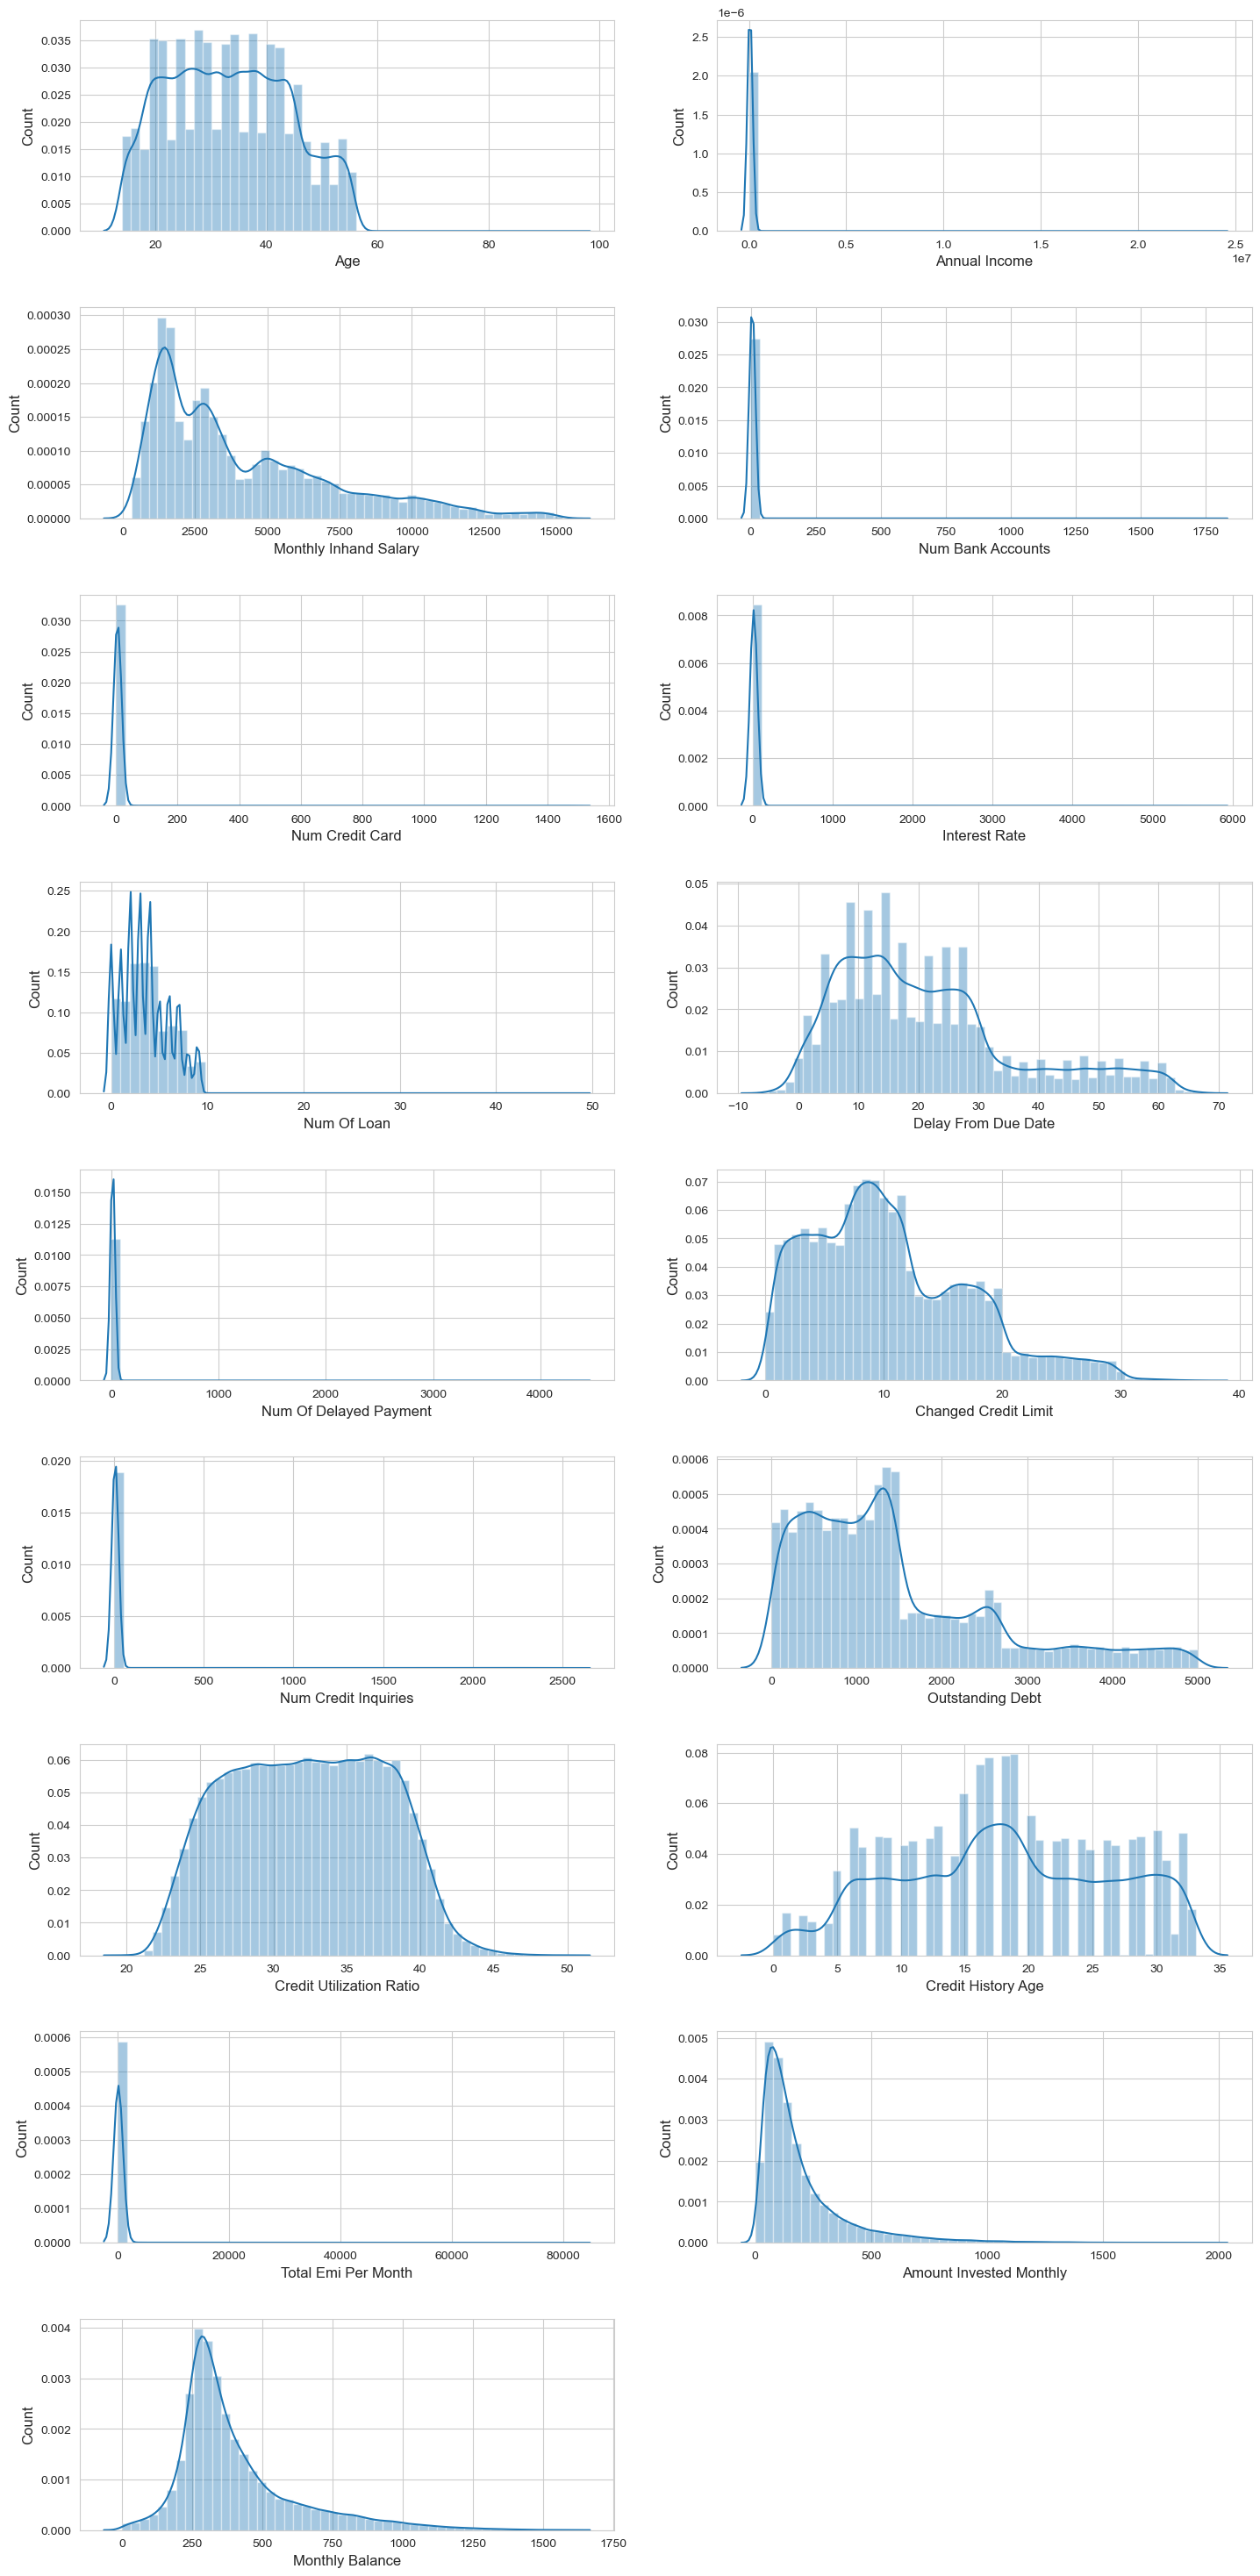

In [76]:
# distribution check for continuous columns

plt.figure(figsize=(15,30))
n_plot = len(con)
n_cols = 2
n_rows = (n_plot + n_cols - 1) // n_cols

for index, i in enumerate(con):
    plt.subplot(n_rows, n_cols, index+1) 
    ax = sns.distplot(df[i])
    plt.xlabel(i.replace('_', ' ').title(), fontsize=12)  
    plt.ylabel('Count', fontsize=12)
plt.tight_layout(pad=3.0) 
plt.show()   

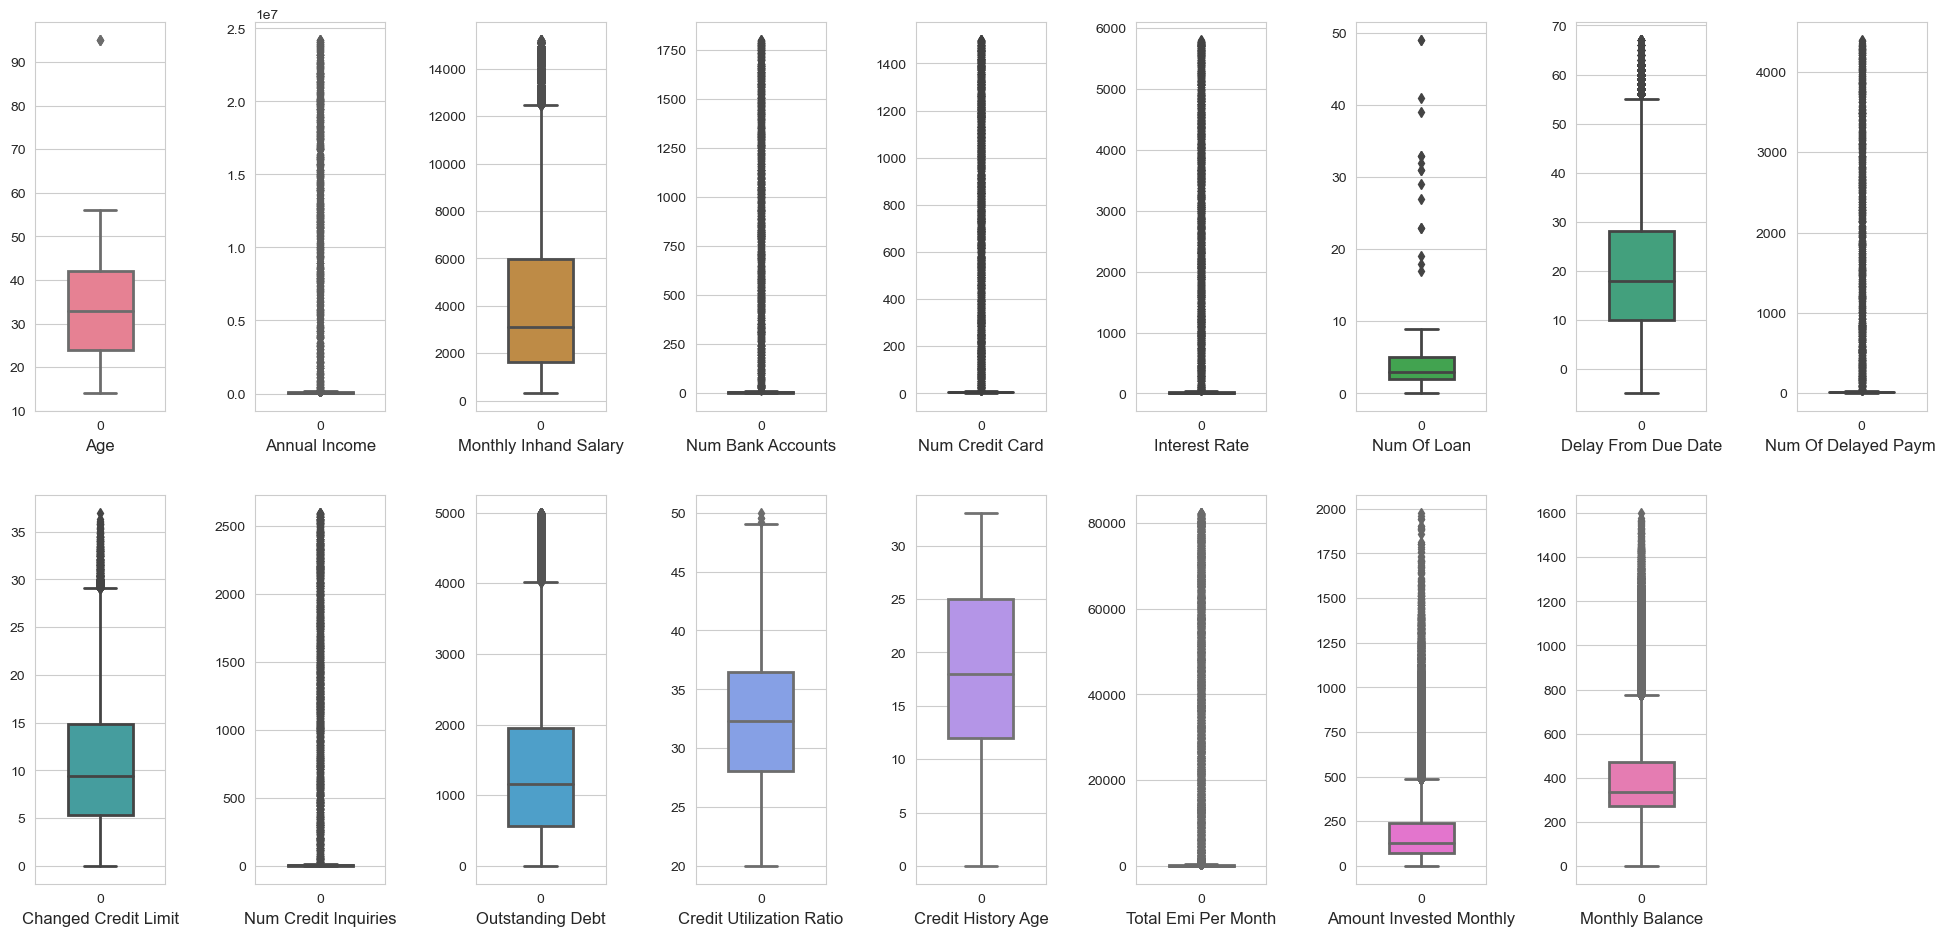

In [77]:
# outliers check for continuous columns

plt.figure(figsize=(20, 10))
n_plot = len(con)
n_cols = 9
n_rows = (n_plot + n_cols - 1) // n_cols

colors = sns.color_palette("husl", n_plot)

for index, i in enumerate(con):
    plt.subplot(n_rows, n_cols, index + 1) 
    ax = sns.boxplot(df[i], color=colors[index], linewidth=2, width=0.5) 
    plt.xlabel(i.replace('_', ' ').title(), fontsize=12)   
    plt.ylabel('', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout(pad=3.0) 
plt.show()
 

In [78]:
# continuous columns stats

pd.options.display.float_format = '{:.2f}'.format
df[con].astype(float).describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00
mean,33.31,157319.62,4200.40,17.08,22.52,72.26,3.53,21.07,30.64,10.45,27.24,1427.27,32.29,18.02,1402.80,195.84,402.96
std,10.77,1318480.72,3187.75,117.45,129.23,465.37,2.47,14.87,219.03,6.67,190.65,1155.45,5.12,8.32,8293.36,195.52,213.85
min,14.00,7005.93,303.65,-1.00,0.00,1.00,0.00,-5.00,-3.00,0.00,0.00,0.23,20.00,0.01,0.00,0.00,0.01
25%,24.00,19453.05,1628.27,3.00,4.00,8.00,2.00,10.00,9.00,5.34,3.00,566.77,28.05,12.00,30.34,74.51,270.21
50%,33.00,37550.74,3097.03,6.00,5.00,13.00,3.00,18.00,14.00,9.39,6.00,1166.88,32.31,18.03,69.30,131.25,337.10
75%,42.00,72629.12,5966.19,7.00,7.00,20.00,5.00,28.00,18.00,14.84,9.00,1948.98,36.50,25.02,161.50,239.16,471.48
max,95.00,24198062.00,15204.63,1798.00,1499.00,5797.00,49.00,67.00,4397.00,36.97,2597.00,4998.07,50.00,33.08,82331.00,1977.33,1602.04


In [79]:
# Continuous columns to numeric-type

for i in con:
    df[i] = pd.to_numeric(df[i], errors='coerce')

In [80]:
# Quantile comparison

for i in con:
    print(i, df[i].quantile(0.95))

Age 52.0
Annual_Income 133903.21950000018
Monthly_Inhand_Salary 10834.46
Num_Bank_Accounts 10.0
Num_Credit_Card 10.0
Interest_Rate 33.0
Num_of_Loan 8.0
Delay_from_due_date 54.0
Num_of_Delayed_Payment 24.0
Changed_Credit_Limit 23.59
Num_Credit_Inquiries 13.0
Outstanding_Debt 4078.71
Credit_Utilization_Ratio 40.220977390508565
Credit_History_Age 31.09
Total_EMI_per_month 439.6376889977788
Amount_invested_monthly 599.5698899363892
Monthly_Balance 862.4091137089242


In [81]:
df[df['Age']>60]

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
37455,CUS_0x7e94,January,95,Engineer,46162.62,3548.89,10,5,16,2.00,"Personal Loan, and Debt Consolidation Loan",43,19,6.45,6.00,Bad,1788.63,35.39,15.05,Yes,65.96,288.65,Low_spent_Small_value_payments,290.29,Standard
64084,CUS_0xdc8,May,95,Doctor,28169.69,2171.47,7,3,15,0.00,Not Specified,13,16,9.95,8.00,Standard,330.54,28.90,29.01,No,0.00,146.17,Low_spent_Large_value_payments,340.98,Standard
76942,CUS_0x1dd3,May,95,Manager,68484.44,5684.04,5,7,5,5.00,"and Home Equity Loan, Not Specified, Home Equi...",12,20,12.52,8.00,Standard,105.41,28.43,12.05,NM,225.54,220.00,High_spent_Small_value_payments,382.87,Standard


In [82]:
df[df['Annual_Income']>1337462].shape[0]

784

"Upon analysis of distribution, box plots, and statistical summaries, it's clear that four columns contain negative values, likely impractical. Converting them to positive is necessary for further analysis. Moreover, significant discrepancies between the 75th percentile and maximum values indicate outliers across various columns, with most box plots showing outliers.Skewness is also evident in distribution plots."
- First, let's assess the correlation. 


In [83]:
# # removing Outliers

# df2 = pd.DataFrame()
# df2 = df

# for i in con:
#     df2 = df2[df2[i] <= df2[i].quantile(0.99)]
# df2.head(2)        

In [84]:
df.shape

(97930, 25)

In [85]:
# converting object data into numerical

le = LabelEncoder()
for i in df.columns:
    if df[i].dtype == "object":
        df[i] = le.fit_transform(df[i])

In [86]:
# negative to positive

for column in df.columns:
    if (df[column] < 0).any():
        df[column] = df[column].abs()

df.head()

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,12320,2,23,12,19114.12,1824.84,3,4,3,4.00,2046,1,5,11.27,4.00,1,809.98,31.94,22.02,1,49.57,118.28,3,284.63,0
1,12320,6,23,12,19114.12,1824.84,3,4,3,4.00,2046,3,7,11.27,4.00,1,809.98,28.61,22.03,1,49.57,81.70,4,331.21,0
2,12320,0,23,12,19114.12,1824.84,3,4,3,4.00,2046,5,4,6.27,4.00,1,809.98,31.38,22.04,1,49.57,199.46,5,223.45,0
3,12320,7,23,12,19114.12,1824.84,3,4,3,4.00,2046,6,5,11.27,4.00,1,809.98,24.80,22.05,1,49.57,41.42,1,341.49,0
4,12320,5,23,12,19114.12,1824.84,3,4,3,4.00,2046,8,4,9.27,4.00,1,809.98,27.26,22.06,1,49.57,62.43,1,340.48,0


In [87]:
# scaling the data for analysis

x = df.drop(columns=['Credit_Score'], axis=1)
y = df['Credit_Score']
std = StandardScaler()
x_scaled = std.fit_transform(x)

In [88]:
# going with VIF to check multicollinearity and also for feature selection


vif_data_scaled = pd.DataFrame()
vif_data_scaled["Variable"] = x.columns
vif_data_scaled["VIF"] = [variance_inflation_factor(x, i) for i in range(x_scaled.shape[1])]

vif_data_scaled

,Variable,VIF
0,Customer_ID,3.89
1,Month,3.26
2,Age,10.30
3,Occupation,3.53
4,Annual_Income,1.02
5,Monthly_Inhand_Salary,23.24
6,Num_Bank_Accounts,1.02
7,Num_Credit_Card,1.03
8,Interest_Rate,1.02
9,Num_of_Loan,6.48




- **Low Multicollinearity (VIF < 5):** Variables like Annual Income, Number of Loans, and Credit Inquiries show low correlation with other predictors. They are important for credit scoring.

- **Moderate Multicollinearity (5 < VIF < 10):** Variables such as Credit History Age and Monthly Balance display moderate correlation but remain relevant for credit assessment.

- **High Multicollinearity (VIF > 10):** Age, Monthly Inhand Salary, and Payment Behavior exhibit high correlation with other variables, potentially affecting coefficient reliability. However, they remain essential for credit scoring.

- **Extreme Multicollinearity (VIF > 20):** Credit Utilization Ratio and Monthly Balance suffer from severe multicollinearity, requiring careful consideration in model building despite their importance in credit scoring.

In [89]:
df1 = pd.concat([pd.DataFrame(x_scaled, columns=x.columns), y], axis=1)

<Axes: >

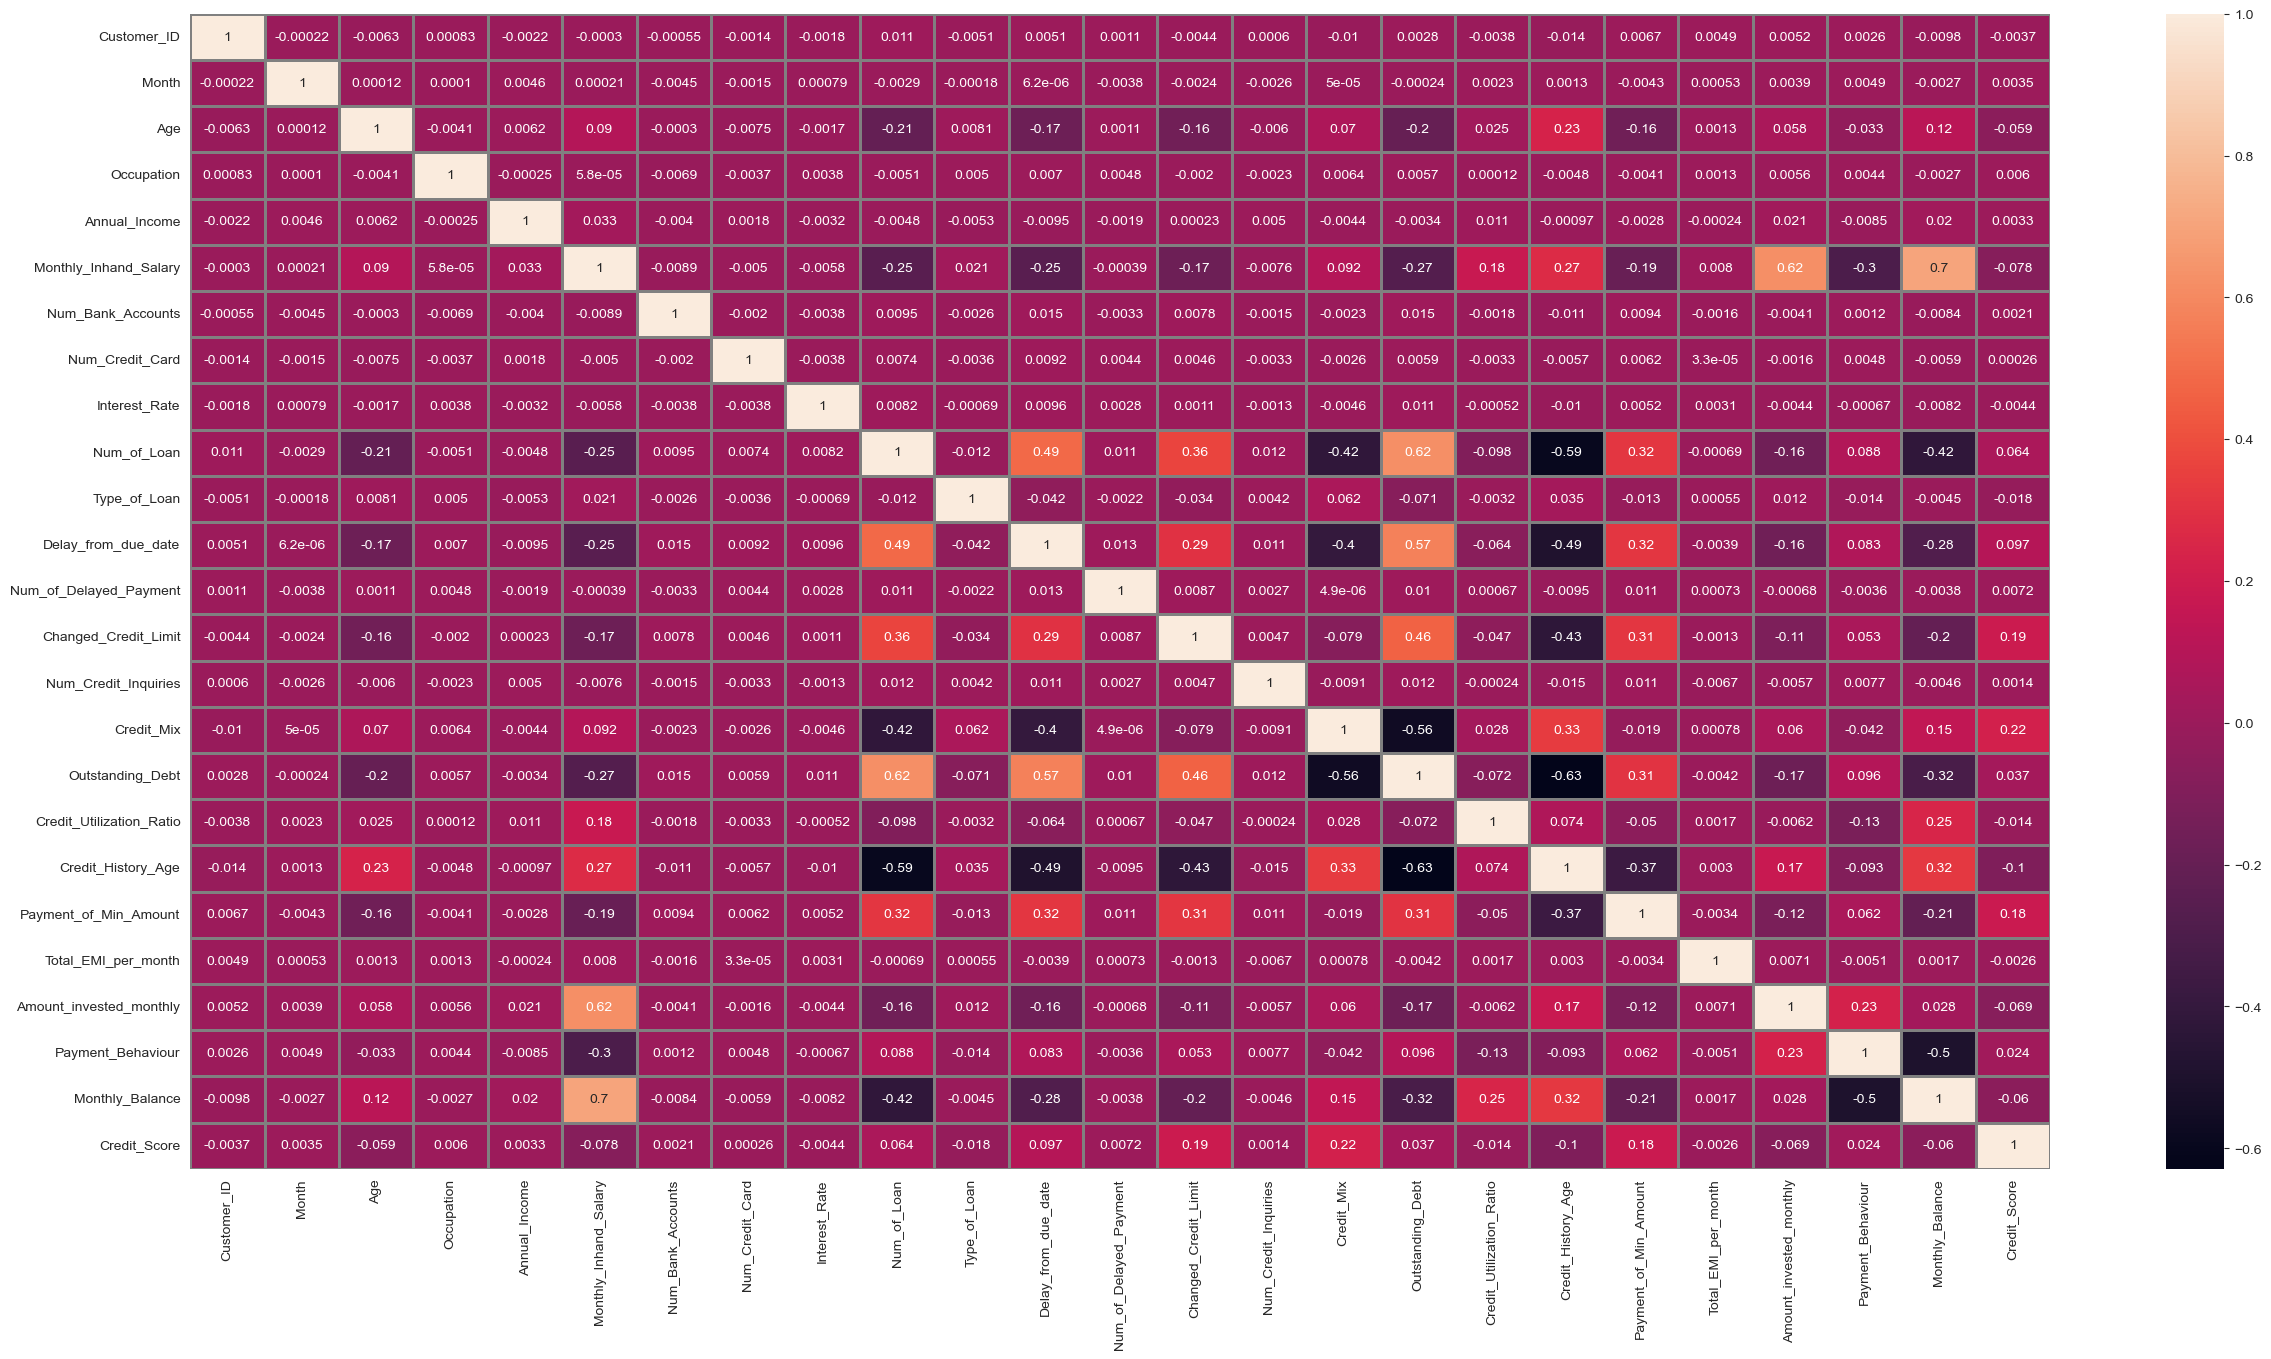

In [90]:
# using heatmap to check correlation and multicollinearity

plt.figure(figsize=(30,15))
sns.heatmap(df.corr(),annot=True,linecolor='grey',linewidths=2)

Looking at the correlation matrix:
- Age, Monthly Inhand Salary, Num of Loan, Delay from Due Date, Changed Credit Limit, and Credit History Age are notably related to Credit Score.
- Age and Monthly Inhand Salary are particularly strong predictors.
- Multicollinearity is observed among several variables, such as Monthly Inhand Salary and Num of Loan, and Delay from Due Date and Num of Delayed Payment.
- Important predictors for Credit Score include Age, Monthly Inhand Salary, Num of Loan, and Credit History Age. However, multicollinearity should be considered when selecting variables for modeling.

In [91]:
# using pca for component reduction

from sklearn.decomposition import PCA

pca = PCA()
principal_components = pca.fit_transform(x_scaled)

explained_variance = pca.explained_variance_ratio_

print("Explained Variance Ratio: ", explained_variance)

Explained Variance Ratio:  [0.17271535 0.07063944 0.05785264 0.04721323 0.04230235 0.04209564
 0.04200536 0.04196378 0.0417705  0.0415638  0.04149193 0.04143339
 0.04133471 0.04115091 0.04095528 0.03790654 0.03702832 0.02927447
 0.0223524  0.02049027 0.01820637 0.0148111  0.01111212 0.00233011]


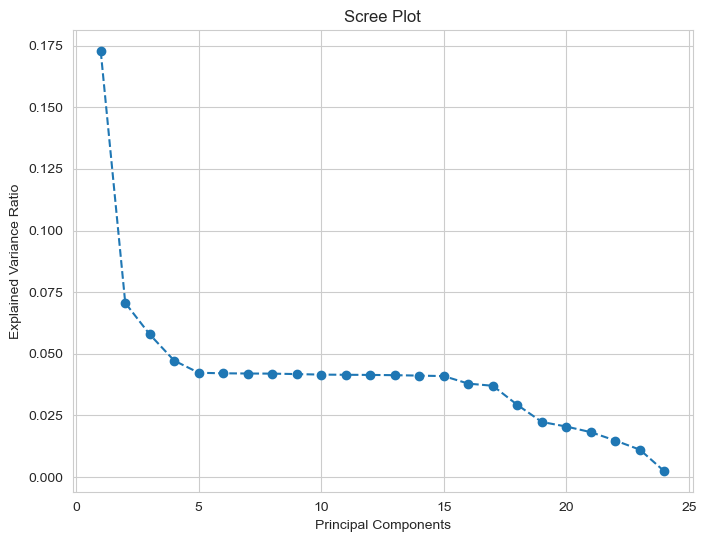

In [92]:
# scree plot for checking variance with components

plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [93]:
# checking those columns which are able to expain 70% of data

cumulative_variance = np.cumsum(explained_variance)

num_components = 15

selected_features = x.columns[:num_components]

print("Selected Features:")
print(selected_features)

Selected Features:
Index(['Customer_ID', 'Month', 'Age', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries'],
      dtype='object')


1. **Age:** Strong predictor with high importance for credit scoring.
2. **Monthly Inhand Salary:** Strong predictor with high importance.
3. **Num of Loan:** Moderate importance, low multicollinearity.
4. **Delay from Due Date:** Moderate importance, low multicollinearity.
5. **Changed Credit Limit:** Moderate importance, low multicollinearity.
6. **Credit History Age:** Strong predictor with moderate multicollinearity.
7. **Num Credit Inquiries:** Moderate importance, low multicollinearity.
8. **Annual Income:** Low multicollinearity, moderate importance.
9. **Num Bank Accounts:** Low multicollinearity, moderate importance.
10. **Num Credit Card:** Low multicollinearity, moderate importance.

These variables are selected based on their importance for credit scoring, considering both their predictive power and the level of multicollinearity they exhibit.

In [94]:
df.columns

Index(['Customer_ID', 'Month', 'Age', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [95]:
# Remove Outliers and skewness from these these columns

df_final = df[['Age','Monthly_Inhand_Salary','Num_of_Loan','Delay_from_due_date','Changed_Credit_Limit',
               'Credit_History_Age','Num_Credit_Inquiries','Annual_Income','Num_Bank_Accounts','Num_Credit_Card','Credit_Score']]

In [96]:
df_final.describe()

,Age,Monthly_Inhand_Salary,Num_of_Loan,Delay_from_due_date,Changed_Credit_Limit,Credit_History_Age,Num_Credit_Inquiries,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Credit_Score
count,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00,97930.00
mean,33.31,4200.40,3.53,21.10,10.45,18.02,27.24,157319.62,17.08,22.52,1.35
std,10.77,3187.75,2.47,14.83,6.67,8.32,190.65,1318480.72,117.45,129.23,0.76
min,14.00,303.65,0.00,0.00,0.00,0.01,0.00,7005.93,0.00,0.00,0.00
25%,24.00,1628.27,2.00,10.00,5.34,12.00,3.00,19453.05,3.00,4.00,1.00
50%,33.00,3097.03,3.00,18.00,9.39,18.03,6.00,37550.74,6.00,5.00,2.00
75%,42.00,5966.19,5.00,28.00,14.84,25.02,9.00,72629.12,7.00,7.00,2.00
max,95.00,15204.63,49.00,67.00,36.97,33.08,2597.00,24198062.00,1798.00,1499.00,2.00


In [97]:
# quantile check

for i in df_final:
    print(i, df[i].quantile(0.99))

Age 55.0
Monthly_Inhand_Salary 13830.866666666669
Num_of_Loan 9.0
Delay_from_due_date 61.0
Changed_Credit_Limit 28.81
Credit_History_Age 33.0
Num_Credit_Inquiries 1057.7100000000064
Annual_Income 177907.72
Num_Bank_Accounts 441.7100000000064
Num_Credit_Card 849.0
Credit_Score 2.0


In [98]:
# Age
df_final =  df_final[df_final['Age']<90]

# Num_of_Loan
df_final = df_final[df_final['Num_of_Loan'] <= 10]

# Num_Credit_Inquiries
df_final = df_final[df_final['Num_Credit_Inquiries'] <= 20]

# Annual_Income
df_final = df_final[df_final['Annual_Income'] <= 133903]

# Num_Bank_Accounts
df_final = df_final[df_final['Num_Bank_Accounts'] <= 10]

# Num_Credit_Card
df_final = df_final[df_final['Num_Credit_Card'] <= 10]

In [99]:
df_final.shape

(88181, 11)

In [100]:
print('Data Loss : ', df.shape[0]-df_final.shape[0], "Rows")

Data Loss :  9749 Rows


### ML Model Preperation

In [101]:
# scaling the data 

df_model = df_final[['Age', 'Monthly_Inhand_Salary', 'Num_of_Loan', 'Delay_from_due_date', 'Changed_Credit_Limit',
                'Credit_History_Age', 'Num_Credit_Inquiries', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card']]

X = df_model
Y = df_final['Credit_Score']
std = StandardScaler()
x_scaled = std.fit_transform(X)
X = x_scaled
# X = pd.DataFrame(data = x_scaled,columns=df_model.columns, index=False)

### Logistic regression

In [102]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=99, test_size=.3)
log_reg=LogisticRegression()
log_reg.fit(X_train,Y_train)
y_pred=log_reg.predict(X_test)

X_train_with_intercept = sm.add_constant(X_train)
log_reg_mn = sm.MNLogit(Y_train, X_train_with_intercept)
log_reg_mn_fit = log_reg_mn.fit()

print('\033[1m'+'Logistics Regression Evaluation'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of Logistics Regression :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Precision Score of Logistics Regression :'+'\033[0m', precision_score(Y_test, y_pred,average='micro'))
print('\n')
print('\033[1m'+'Confusion matrix of Logistics Regression :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of Logistics Regression'+'\033[0m \n',classification_report(Y_test, y_pred))
print()
print('\033[1m' + 'Logistic Regression Coefficients and Standard Errors (Training):' + '\033[0m')
print(log_reg_mn_fit.summary())
print()

from sklearn.model_selection import cross_validate
CV_results = cross_validate(log_reg, X, Y, cv=5, scoring=['precision_micro'])
print('\033[1m' + 'Cross Validation Scores:' + '\033[0m\n')
print("Precision CV Scores (micro):", CV_results['test_precision_micro'])
print("Mean Precision CV Score (micro):", CV_results['test_precision_micro'].mean())
print("Std deviation:", CV_results['test_precision_micro'].std())


Optimization terminated successfully.
         Current function value: 0.798951
         Iterations 8
Logistics Regression Evaluation


Accuracy Score of Logistics Regression : 0.6306180306180306


Precision Score of Logistics Regression : 0.6306180306180306


Confusion matrix of Logistics Regression : 
 [[ 1442    66  2917]
 [  155  3840  3835]
 [  865  1934 11401]]


classification Report of Logistics Regression 
               precision    recall  f1-score   support

           0       0.59      0.33      0.42      4425
           1       0.66      0.49      0.56      7830
           2       0.63      0.80      0.70     14200

    accuracy                           0.63     26455
   macro avg       0.62      0.54      0.56     26455
weighted avg       0.63      0.63      0.61     26455


Logistic Regression Coefficients and Standard Errors (Training):
                          MNLogit Regression Results                          
Dep. Variable:           Credit_Score   No. Observatio

### Random Forest Classifier

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier
import statsmodels.api as sm

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=99, test_size=0.3)
rf_classifier = RandomForestClassifier(random_state=62)
rf_classifier.fit(X_train, Y_train)

# Predictions with Random Forest
y_pred_rf = rf_classifier.predict(X_test)


# Print evaluation metrics for Random Forest
print('\033[1m' + 'Random Forest Evaluation' + '\033[0m')
print('\n')
print('\033[1m' + 'Accuracy Score of Random Forest:' + '\033[0m', accuracy_score(Y_test, y_pred_rf))
print('\n')
print('\033[1m' + 'Precision Score of Random Forest:' + '\033[0m', precision_score(Y_test, y_pred_rf, average='micro'))
print('\n')
print('\033[1m' + 'Confusion matrix of Random Forest:' + '\033[0m \n', confusion_matrix(Y_test, y_pred_rf))
print('\n')
print('\033[1m' + 'Classification Report of Random Forest' + '\033[0m \n', classification_report(Y_test, y_pred_rf))
print()


from sklearn.model_selection import cross_validate
CV_results = cross_validate(rf_classifier, X, Y, cv=5, scoring=['precision_micro'])
print('\033[1m' + 'Cross Validation Scores:' + '\033[0m\n')
print("Precision CV Scores (micro):", CV_results['test_precision_micro'])
print("Mean Precision CV Score (micro):", CV_results['test_precision_micro'].mean())
print("Std deviation:", CV_results['test_precision_micro'].std())

Random Forest Evaluation


Accuracy Score of Random Forest: 0.7979209979209979


Precision Score of Random Forest: 0.7979209979209979


Confusion matrix of Random Forest: 
 [[ 3259    14  1152]
 [   16  6280  1534]
 [  971  1659 11570]]


Classification Report of Random Forest 
               precision    recall  f1-score   support

           0       0.77      0.74      0.75      4425
           1       0.79      0.80      0.80      7830
           2       0.81      0.81      0.81     14200

    accuracy                           0.80     26455
   macro avg       0.79      0.78      0.79     26455
weighted avg       0.80      0.80      0.80     26455


Cross Validation Scores:

Precision CV Scores (micro): [0.63587912 0.6572352  0.65179179 0.63359038 0.64867317]
Mean Precision CV Score (micro): 0.6454339319673649
Std deviation: 0.009184215478326565


**So, we're opting for the Random Forest classifier for hyperparameter tuning, leveraging its superior performance metrics over Logistic Regression. The Random Forest model outperforms Logistic Regression in accuracy, precision, recall, and F1-score, with an accuracy of 0.80 compared to 0.63 for Logistic Regression. Additionally, the precision and recall values consistently favor the Random Forest model, indicating better overall performance.**

**While Logistic Regression provides coefficients revealing significant relationships between predictors (x1 to x10) and the target variable (Credit_Score), and most predictors are highly significant (p<0.001), its overall performance falls short compared to the Random Forest model.**

**Therefore, we're proceeding with hyperparameter tuning for the Random Forest model to further enhance its predictive capabilities.**

In [104]:
# hyper parameter Tuning for increasing model performance

rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [5, 10, 15],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [105]:
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, Y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 15}
Best Score:  0.7789262336530405


In [106]:
# Initialize the Random Forest Classifier with the best parameters
best_rfc = RandomForestClassifier(n_estimators=66, max_depth=None, min_samples_split=4, min_samples_leaf=1,criterion='entropy', 
                                   bootstrap=True,  random_state=62,  n_jobs=-1)  


# Fit the classifier on the training data
best_rfc.fit(X_train, Y_train)

# Make predictions on the test data
y_pred_best = best_rfc.predict(X_test)

# Print the evaluation metrics
print('\033[1m' + 'Random Forest Classifier' + '\033[0m')
print('\n')
print('\033[1m' + 'Accuracy Score of Random Forest Classifier :' + '\033[0m', accuracy_score(Y_test, y_pred_best))
print('\n')
print('\033[1m' + 'Precision Score of Random Forest Classifier :' + '\033[0m', precision_score(Y_test, y_pred_best,average='micro'))
print('\n')
print('\033[1m' + 'Confusion matrix of Random Forest Classifier :' + '\033[0m \n', confusion_matrix(Y_test, y_pred_best))
print('\n')
print('\033[1m' + 'classification Report of Random Forest Classifier' + '\033[0m \n', classification_report(Y_test, y_pred_best))
print('\n')
CV_results = cross_validate(best_rfc, X, Y, cv=5, scoring=['precision_micro'])
print('\033[1m' + 'Cross Validation Scores:' + '\033[0m\n')
print("Precision CV Scores (micro):", CV_results['test_precision_micro'])
print("Mean Precision CV Score (micro):", CV_results['test_precision_micro'].mean())
print("Std deviation:", CV_results['test_precision_micro'].std())

Random Forest Classifier


Accuracy Score of Random Forest Classifier : 0.7986391986391986


Precision Score of Random Forest Classifier : 0.7986391986391986


Confusion matrix of Random Forest Classifier : 
 [[ 3185    21  1219]
 [   21  6367  1442]
 [  925  1699 11576]]


classification Report of Random Forest Classifier 
               precision    recall  f1-score   support

           0       0.77      0.72      0.74      4425
           1       0.79      0.81      0.80      7830
           2       0.81      0.82      0.81     14200

    accuracy                           0.80     26455
   macro avg       0.79      0.78      0.79     26455
weighted avg       0.80      0.80      0.80     26455



Cross Validation Scores:

Precision CV Scores (micro): [0.64585814 0.65337945 0.64878657 0.63818326 0.65264232]
Mean Precision CV Score (micro): 0.6477699494427405
Std deviation: 0.00550998468165256


**Following hyperparameter tuning, the Random Forest Classifier showed slight improvements in performance. Accuracy and precision scores remained steady around 0.80 and 0.79-0.80, respectively. While confusion matrices and classification reports stayed consistent, precision cross-validation scores indicated a small boost in mean precision, from around 0.645 to 0.648, with slightly reduced standard deviation, implying better model stability. Overall, tuning subtly enhanced predictive capability without major changes in performance.**

In [107]:
# save model

import joblib

# Save the trained model to a file
joblib.dump(best_rfc, 'random_forest_classifier_model.pkl')

['random_forest_classifier_model.pkl']

In [124]:
y = np.array(Y)

random_indices = random.sample(range(len(X)), 10)

predictions = []
actual_values = []
match_statuses = []

for index in random_indices:
    data_instance = X[index].reshape(1, -1)
    prediction = best_rfc.predict(data_instance)
    prediction = le.inverse_transform(prediction)
    
    actual_value = y[index] 
    actual_value = le.inverse_transform([actual_value])  
    
    predictions.append(prediction[0])  
    actual_values.append(actual_value[0]) 
    
    if prediction == actual_value:
        match_status = "Yes"
    else:
        match_status = "No"
    
    match_statuses.append(match_status)
    

# Create a DataFrame
df = pd.DataFrame({
    'Index': random_indices,
    'Prediction': predictions,
    'Actual Value': actual_values,
    'Match': match_statuses
})

print("\nPerdicting random values:")
df



Perdicting random values:


,Index,Prediction,Actual Value,Match
0,79883,Good,Good,Yes
1,26554,Good,Good,Yes
2,20526,Standard,Standard,Yes
3,4479,Poor,Poor,Yes
4,70163,Good,Good,Yes
5,52485,Standard,Standard,Yes
6,30574,Standard,Standard,Yes
7,73784,Standard,Standard,Yes
8,17210,Standard,Standard,Yes
9,64343,Standard,Standard,Yes


                                                         Thanks